# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

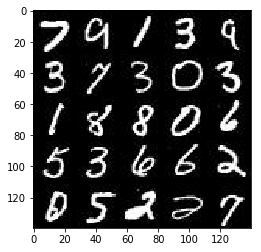

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

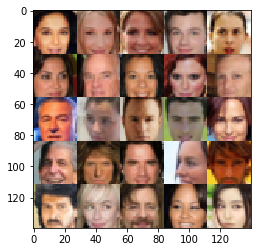

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_fake = tf.placeholder(tf.float32, (None, z_dim), name='input_fake')
    learning_rate = tf.placeholder(tf.float64, None, name='learning_rate')

    return input_real, input_fake, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 28x28x(3 or 1)
        x0 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        x0 = tf.maximum(alpha * x0, x0)
        # 14x14x32
        x1 = tf.layers.conv2d(x0, 64, 5, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x64
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 4x4x128
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # now size is 2x2x256
        
        x4 = tf.reshape(x3, (-1, 2*2*256))
        logits = tf.layers.dense(x4, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not(is_train)):
        alpha=0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x64
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 32x32x32
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_fake, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_fake, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={ input_real: batch_images, input_fake: batch_z, lr: learning_rate })
                _ = sess.run(g_opt, feed_dict={ input_fake: batch_z, input_real: batch_images, lr: learning_rate })
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_fake: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_fake: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_fake, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.8623... Generator Loss: 0.0011
Epoch 1/2... Discriminator Loss: 0.0315... Generator Loss: 6.1362
Epoch 1/2... Discriminator Loss: 0.0123... Generator Loss: 6.8962
Epoch 1/2... Discriminator Loss: 0.0629... Generator Loss: 8.3457
Epoch 1/2... Discriminator Loss: 4.5575... Generator Loss: 0.0174
Epoch 1/2... Discriminator Loss: 0.6745... Generator Loss: 0.9557
Epoch 1/2... Discriminator Loss: 0.2910... Generator Loss: 1.9079
Epoch 1/2... Discriminator Loss: 2.5343... Generator Loss: 7.7577
Epoch 1/2... Discriminator Loss: 0.6229... Generator Loss: 4.3771
Epoch 1/2... Discriminator Loss: 0.1577... Generator Loss: 2.7647


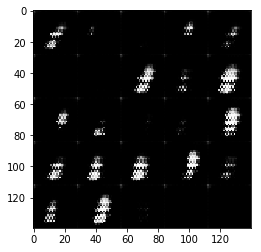

Epoch 1/2... Discriminator Loss: 1.5935... Generator Loss: 0.4424
Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 1.0890
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 0.7291
Epoch 1/2... Discriminator Loss: 1.0813... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 1.0856... Generator Loss: 1.3710
Epoch 1/2... Discriminator Loss: 0.8086... Generator Loss: 0.9687
Epoch 1/2... Discriminator Loss: 0.9283... Generator Loss: 0.6880
Epoch 1/2... Discriminator Loss: 0.8814... Generator Loss: 1.5153
Epoch 1/2... Discriminator Loss: 1.2078... Generator Loss: 0.5241
Epoch 1/2... Discriminator Loss: 1.1531... Generator Loss: 1.4533


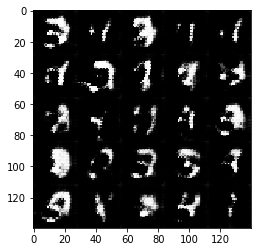

Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 0.4532
Epoch 1/2... Discriminator Loss: 1.5790... Generator Loss: 2.3806
Epoch 1/2... Discriminator Loss: 0.9953... Generator Loss: 0.7238
Epoch 1/2... Discriminator Loss: 0.8412... Generator Loss: 0.8347
Epoch 1/2... Discriminator Loss: 0.8478... Generator Loss: 1.6907
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 0.9764
Epoch 1/2... Discriminator Loss: 1.1318... Generator Loss: 0.6263
Epoch 1/2... Discriminator Loss: 0.8007... Generator Loss: 1.1521
Epoch 1/2... Discriminator Loss: 0.9860... Generator Loss: 0.7894
Epoch 1/2... Discriminator Loss: 1.0349... Generator Loss: 0.9126


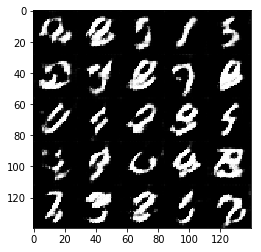

Epoch 1/2... Discriminator Loss: 1.2968... Generator Loss: 0.7503
Epoch 1/2... Discriminator Loss: 1.6538... Generator Loss: 0.3208
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.6572
Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 1.4773
Epoch 1/2... Discriminator Loss: 1.5165... Generator Loss: 0.3791
Epoch 1/2... Discriminator Loss: 1.2023... Generator Loss: 0.9677
Epoch 1/2... Discriminator Loss: 1.3609... Generator Loss: 0.6408
Epoch 1/2... Discriminator Loss: 1.4044... Generator Loss: 1.3111
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 1.2543
Epoch 1/2... Discriminator Loss: 1.2767... Generator Loss: 0.5261


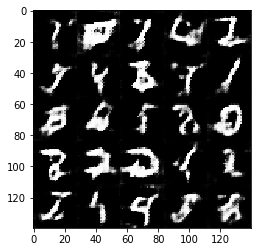

Epoch 1/2... Discriminator Loss: 0.9488... Generator Loss: 1.0008
Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 0.5241
Epoch 1/2... Discriminator Loss: 1.0729... Generator Loss: 1.0477
Epoch 1/2... Discriminator Loss: 0.8638... Generator Loss: 1.1849
Epoch 1/2... Discriminator Loss: 0.9931... Generator Loss: 1.1577
Epoch 1/2... Discriminator Loss: 1.0706... Generator Loss: 0.7078
Epoch 1/2... Discriminator Loss: 1.2112... Generator Loss: 0.6731
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 0.9007
Epoch 1/2... Discriminator Loss: 1.1977... Generator Loss: 0.6578
Epoch 1/2... Discriminator Loss: 1.4035... Generator Loss: 2.8003


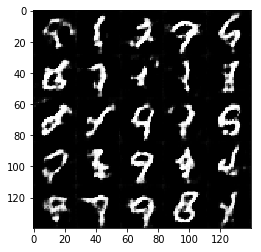

Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 0.6111
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 0.9858
Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 0.8252
Epoch 1/2... Discriminator Loss: 1.3438... Generator Loss: 0.4571
Epoch 1/2... Discriminator Loss: 1.5126... Generator Loss: 0.3402
Epoch 1/2... Discriminator Loss: 0.8319... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 0.8374... Generator Loss: 1.5101
Epoch 1/2... Discriminator Loss: 1.3430... Generator Loss: 0.5071
Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 0.4725
Epoch 1/2... Discriminator Loss: 0.8568... Generator Loss: 0.9160


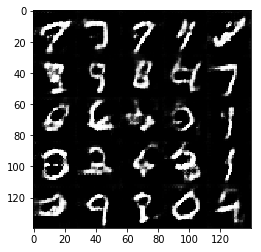

Epoch 1/2... Discriminator Loss: 0.9717... Generator Loss: 0.7755
Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 0.6981
Epoch 1/2... Discriminator Loss: 1.2425... Generator Loss: 0.5849
Epoch 1/2... Discriminator Loss: 0.8248... Generator Loss: 1.0320
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 0.6700
Epoch 1/2... Discriminator Loss: 1.1972... Generator Loss: 1.1329
Epoch 1/2... Discriminator Loss: 0.7941... Generator Loss: 0.9513
Epoch 1/2... Discriminator Loss: 1.1218... Generator Loss: 1.2822
Epoch 1/2... Discriminator Loss: 1.0240... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 0.5883


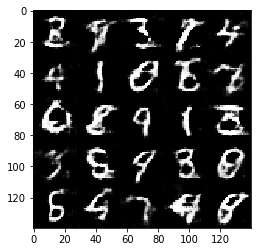

Epoch 1/2... Discriminator Loss: 1.0425... Generator Loss: 1.4129
Epoch 1/2... Discriminator Loss: 0.8975... Generator Loss: 0.8073
Epoch 1/2... Discriminator Loss: 1.5444... Generator Loss: 0.5242
Epoch 1/2... Discriminator Loss: 0.9201... Generator Loss: 0.7943
Epoch 1/2... Discriminator Loss: 1.1109... Generator Loss: 0.9418
Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 0.5886
Epoch 1/2... Discriminator Loss: 1.7171... Generator Loss: 0.2570
Epoch 1/2... Discriminator Loss: 1.0154... Generator Loss: 0.7006
Epoch 1/2... Discriminator Loss: 1.2494... Generator Loss: 1.6385
Epoch 1/2... Discriminator Loss: 0.7335... Generator Loss: 1.0242


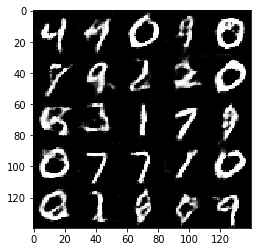

Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 0.7701
Epoch 1/2... Discriminator Loss: 0.9117... Generator Loss: 0.8215
Epoch 1/2... Discriminator Loss: 0.7709... Generator Loss: 1.0670
Epoch 1/2... Discriminator Loss: 1.5627... Generator Loss: 0.3576
Epoch 1/2... Discriminator Loss: 1.1692... Generator Loss: 0.4877
Epoch 1/2... Discriminator Loss: 1.6626... Generator Loss: 0.2922
Epoch 1/2... Discriminator Loss: 1.0007... Generator Loss: 0.8038
Epoch 1/2... Discriminator Loss: 1.3373... Generator Loss: 0.5862
Epoch 1/2... Discriminator Loss: 0.9414... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 1.6556... Generator Loss: 0.2742


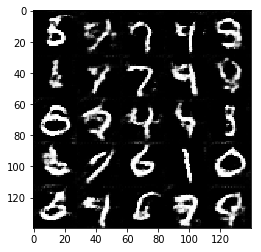

Epoch 1/2... Discriminator Loss: 1.2271... Generator Loss: 0.5015
Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.8874
Epoch 1/2... Discriminator Loss: 0.8447... Generator Loss: 0.9042
Epoch 2/2... Discriminator Loss: 0.9379... Generator Loss: 1.4167
Epoch 2/2... Discriminator Loss: 0.5983... Generator Loss: 1.2732
Epoch 2/2... Discriminator Loss: 0.8299... Generator Loss: 0.7768
Epoch 2/2... Discriminator Loss: 0.4855... Generator Loss: 2.2131
Epoch 2/2... Discriminator Loss: 0.7633... Generator Loss: 1.2035
Epoch 2/2... Discriminator Loss: 0.8322... Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 1.3251... Generator Loss: 0.4347


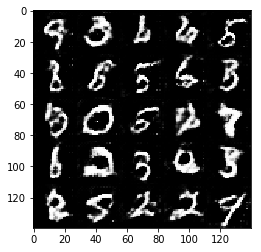

Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.4616
Epoch 2/2... Discriminator Loss: 1.5945... Generator Loss: 0.3156
Epoch 2/2... Discriminator Loss: 0.8361... Generator Loss: 0.9300
Epoch 2/2... Discriminator Loss: 1.1642... Generator Loss: 0.5556
Epoch 2/2... Discriminator Loss: 0.8434... Generator Loss: 1.6000
Epoch 2/2... Discriminator Loss: 1.8400... Generator Loss: 0.2749
Epoch 2/2... Discriminator Loss: 0.8358... Generator Loss: 0.9584
Epoch 2/2... Discriminator Loss: 0.7879... Generator Loss: 1.2360
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 1.6138
Epoch 2/2... Discriminator Loss: 1.1640... Generator Loss: 0.5464


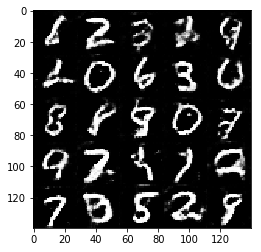

Epoch 2/2... Discriminator Loss: 1.1770... Generator Loss: 0.5331
Epoch 2/2... Discriminator Loss: 1.0787... Generator Loss: 0.6214
Epoch 2/2... Discriminator Loss: 2.1110... Generator Loss: 0.1931
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 1.7486
Epoch 2/2... Discriminator Loss: 1.1761... Generator Loss: 0.4994
Epoch 2/2... Discriminator Loss: 0.7249... Generator Loss: 0.9523
Epoch 2/2... Discriminator Loss: 0.8055... Generator Loss: 1.0136
Epoch 2/2... Discriminator Loss: 0.9117... Generator Loss: 0.8553
Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 0.4644
Epoch 2/2... Discriminator Loss: 1.5285... Generator Loss: 0.3101


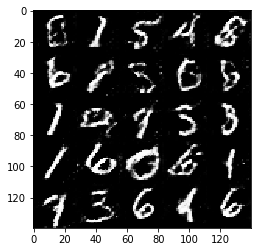

Epoch 2/2... Discriminator Loss: 1.7771... Generator Loss: 0.2494
Epoch 2/2... Discriminator Loss: 1.5587... Generator Loss: 0.3490
Epoch 2/2... Discriminator Loss: 1.2089... Generator Loss: 0.5919
Epoch 2/2... Discriminator Loss: 1.2587... Generator Loss: 0.4453
Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 1.4796
Epoch 2/2... Discriminator Loss: 0.8252... Generator Loss: 0.8405
Epoch 2/2... Discriminator Loss: 0.8540... Generator Loss: 1.0369
Epoch 2/2... Discriminator Loss: 0.8229... Generator Loss: 1.1949
Epoch 2/2... Discriminator Loss: 0.8155... Generator Loss: 1.1520
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 0.4203


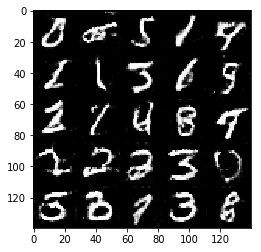

Epoch 2/2... Discriminator Loss: 1.8370... Generator Loss: 0.2277
Epoch 2/2... Discriminator Loss: 1.8860... Generator Loss: 0.2093
Epoch 2/2... Discriminator Loss: 0.8821... Generator Loss: 0.8891
Epoch 2/2... Discriminator Loss: 0.5303... Generator Loss: 1.5444
Epoch 2/2... Discriminator Loss: 1.2276... Generator Loss: 0.4550
Epoch 2/2... Discriminator Loss: 1.6049... Generator Loss: 0.2983
Epoch 2/2... Discriminator Loss: 1.7513... Generator Loss: 0.2580
Epoch 2/2... Discriminator Loss: 1.7320... Generator Loss: 0.3525
Epoch 2/2... Discriminator Loss: 1.2711... Generator Loss: 0.4911
Epoch 2/2... Discriminator Loss: 2.6225... Generator Loss: 3.5822


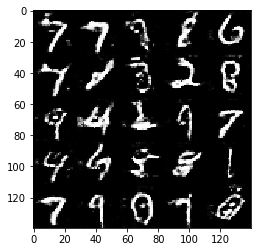

Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 0.7347
Epoch 2/2... Discriminator Loss: 1.3810... Generator Loss: 0.3841
Epoch 2/2... Discriminator Loss: 0.8857... Generator Loss: 1.0449
Epoch 2/2... Discriminator Loss: 1.1440... Generator Loss: 1.4677
Epoch 2/2... Discriminator Loss: 1.4511... Generator Loss: 0.3640
Epoch 2/2... Discriminator Loss: 0.8097... Generator Loss: 1.2535
Epoch 2/2... Discriminator Loss: 0.7857... Generator Loss: 1.3613
Epoch 2/2... Discriminator Loss: 0.7279... Generator Loss: 1.4928
Epoch 2/2... Discriminator Loss: 1.7388... Generator Loss: 1.1784
Epoch 2/2... Discriminator Loss: 0.9299... Generator Loss: 0.9684


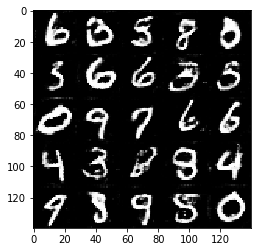

Epoch 2/2... Discriminator Loss: 2.3230... Generator Loss: 0.1441
Epoch 2/2... Discriminator Loss: 1.1181... Generator Loss: 0.9245
Epoch 2/2... Discriminator Loss: 0.7158... Generator Loss: 1.0532
Epoch 2/2... Discriminator Loss: 1.1692... Generator Loss: 0.5482
Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 0.9896
Epoch 2/2... Discriminator Loss: 1.4459... Generator Loss: 0.3691
Epoch 2/2... Discriminator Loss: 0.9147... Generator Loss: 1.2717
Epoch 2/2... Discriminator Loss: 0.7785... Generator Loss: 1.3015
Epoch 2/2... Discriminator Loss: 0.8736... Generator Loss: 1.2873
Epoch 2/2... Discriminator Loss: 0.8796... Generator Loss: 0.9877


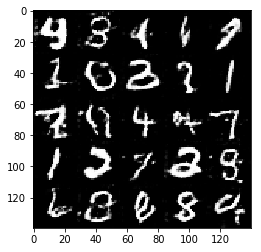

Epoch 2/2... Discriminator Loss: 0.7491... Generator Loss: 1.3948
Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 0.5308
Epoch 2/2... Discriminator Loss: 1.5788... Generator Loss: 3.1287
Epoch 2/2... Discriminator Loss: 0.6030... Generator Loss: 1.1099
Epoch 2/2... Discriminator Loss: 1.1354... Generator Loss: 0.6849
Epoch 2/2... Discriminator Loss: 0.5526... Generator Loss: 1.6987
Epoch 2/2... Discriminator Loss: 0.8382... Generator Loss: 0.9850
Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 0.5253
Epoch 2/2... Discriminator Loss: 1.7725... Generator Loss: 0.2601
Epoch 2/2... Discriminator Loss: 1.2984... Generator Loss: 0.6082


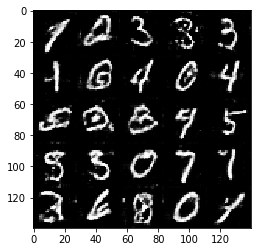

Epoch 2/2... Discriminator Loss: 1.1960... Generator Loss: 0.5425
Epoch 2/2... Discriminator Loss: 1.6274... Generator Loss: 0.2950
Epoch 2/2... Discriminator Loss: 1.1918... Generator Loss: 0.4879
Epoch 2/2... Discriminator Loss: 1.4797... Generator Loss: 0.3743
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 0.8954
Epoch 2/2... Discriminator Loss: 1.4505... Generator Loss: 2.2393
Epoch 2/2... Discriminator Loss: 1.1040... Generator Loss: 0.6193
Epoch 2/2... Discriminator Loss: 1.5089... Generator Loss: 0.3410
Epoch 2/2... Discriminator Loss: 0.8914... Generator Loss: 0.7624
Epoch 2/2... Discriminator Loss: 1.6834... Generator Loss: 0.2935


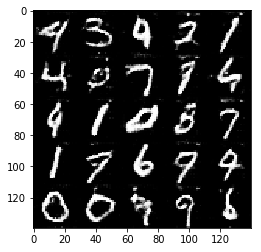

Epoch 2/2... Discriminator Loss: 1.6255... Generator Loss: 0.3022
Epoch 2/2... Discriminator Loss: 1.5725... Generator Loss: 0.3214
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 0.5045
Epoch 2/2... Discriminator Loss: 0.9215... Generator Loss: 0.7093
Epoch 2/2... Discriminator Loss: 1.3039... Generator Loss: 0.4751
Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 0.9184
Epoch 2/2... Discriminator Loss: 1.2472... Generator Loss: 0.4500


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 1.2886
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 1.7141
Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 1.5645
Epoch 1/1... Discriminator Loss: 0.2444... Generator Loss: 2.2886
Epoch 1/1... Discriminator Loss: 0.2352... Generator Loss: 2.1229
Epoch 1/1... Discriminator Loss: 0.1216... Generator Loss: 3.1995
Epoch 1/1... Discriminator Loss: 0.1104... Generator Loss: 2.9668
Epoch 1/1... Discriminator Loss: 0.1386... Generator Loss: 2.9147
Epoch 1/1... Discriminator Loss: 0.0633... Generator Loss: 3.9490
Epoch 1/1... Discriminator Loss: 0.1772... Generator Loss: 2.4117


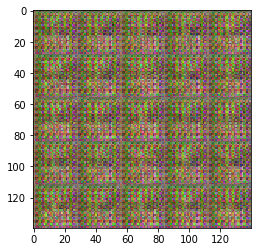

Epoch 1/1... Discriminator Loss: 0.1007... Generator Loss: 4.3824
Epoch 1/1... Discriminator Loss: 0.3255... Generator Loss: 1.6221
Epoch 1/1... Discriminator Loss: 0.1691... Generator Loss: 4.8286
Epoch 1/1... Discriminator Loss: 0.3095... Generator Loss: 3.6164
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 1.8045
Epoch 1/1... Discriminator Loss: 0.3101... Generator Loss: 1.8886
Epoch 1/1... Discriminator Loss: 0.1892... Generator Loss: 2.7655
Epoch 1/1... Discriminator Loss: 0.4187... Generator Loss: 2.2267
Epoch 1/1... Discriminator Loss: 0.4336... Generator Loss: 2.2661
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 0.9713


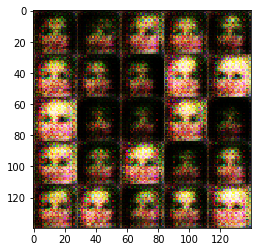

Epoch 1/1... Discriminator Loss: 0.2910... Generator Loss: 2.7964
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 2.3189
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 0.4646... Generator Loss: 1.5941
Epoch 1/1... Discriminator Loss: 0.6965... Generator Loss: 3.5442
Epoch 1/1... Discriminator Loss: 0.4980... Generator Loss: 1.5729
Epoch 1/1... Discriminator Loss: 0.4946... Generator Loss: 2.7822
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.3050
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 1.0199


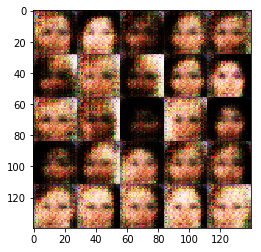

Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 2.0639
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 2.8415
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 0.6000... Generator Loss: 1.5378
Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 1.2055
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 1.5707
Epoch 1/1... Discriminator Loss: 0.7744... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 1.8634
Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 1.7474


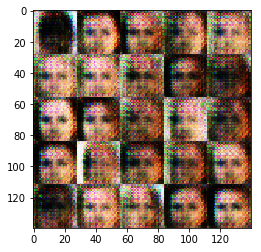

Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 0.5792... Generator Loss: 1.6728
Epoch 1/1... Discriminator Loss: 0.8621... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 1.7511
Epoch 1/1... Discriminator Loss: 0.5641... Generator Loss: 1.5970
Epoch 1/1... Discriminator Loss: 0.6054... Generator Loss: 1.2868
Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 2.0017
Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 1.0104


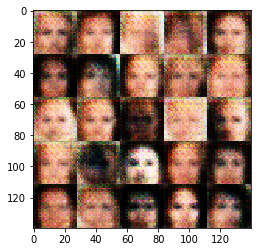

Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.2220
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 1.6148
Epoch 1/1... Discriminator Loss: 0.6113... Generator Loss: 1.8821
Epoch 1/1... Discriminator Loss: 0.6219... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 2.0347
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.6294


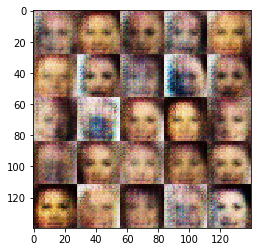

Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 1.5069
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 2.7439
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 1.6884
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 1.1154
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 0.8063... Generator Loss: 1.2951


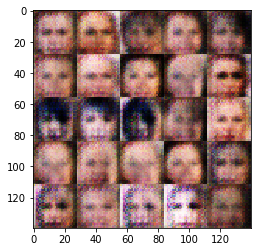

Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 1.3000
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 1.4447
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.4150
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 1.2316
Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 1.8299
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.6269


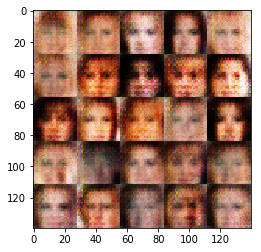

Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 1.2001
Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 1.3211
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 1.3632
Epoch 1/1... Discriminator Loss: 0.6984... Generator Loss: 1.7211
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.4980
Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 1.2714


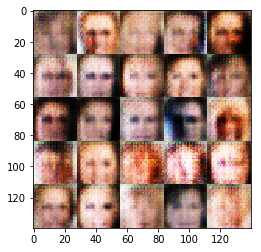

Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 1.1920
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.1550
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.2362
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 1.4685
Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 2.5470
Epoch 1/1... Discriminator Loss: 0.6835... Generator Loss: 1.2097


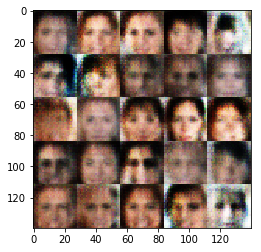

Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 0.7306... Generator Loss: 1.3433
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.0454
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.5383
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 1.3208


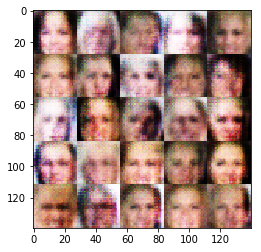

Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 1.9716
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.3793
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 1.9201
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 1.2216
Epoch 1/1... Discriminator Loss: 0.8115... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 1.3228
Epoch 1/1... Discriminator Loss: 0.7233... Generator Loss: 1.6463
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.5263
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 1.6462


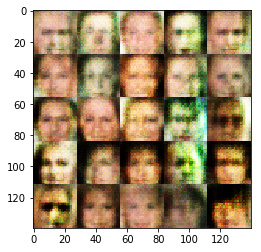

Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.1746
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 1.5124
Epoch 1/1... Discriminator Loss: 0.6511... Generator Loss: 1.3076
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 1.2199
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.4889


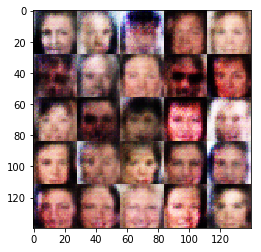

Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 1.8605
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 1.3479
Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 1.1750


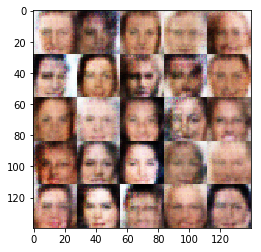

Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.2743
Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.1297


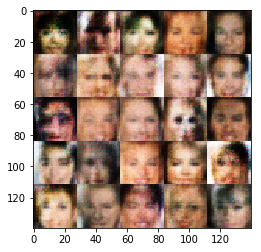

Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.1615
Epoch 1/1... Discriminator Loss: 0.6771... Generator Loss: 1.3373
Epoch 1/1... Discriminator Loss: 0.8605... Generator Loss: 1.2280
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.4252
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 2.0357
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.8089


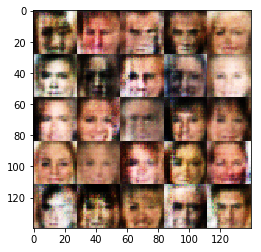

Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.4557
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.4763
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 0.8662... Generator Loss: 1.2987
Epoch 1/1... Discriminator Loss: 0.7832... Generator Loss: 1.2999
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 0.8479... Generator Loss: 1.0011


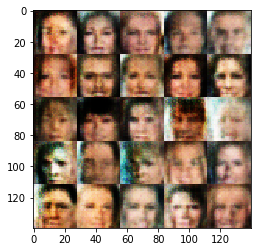

Epoch 1/1... Discriminator Loss: 0.7929... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 1.1499
Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 1.4532
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 1.4966
Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 1.1091
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.3470
Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 1.5524
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 1.8550
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 0.7177... Generator Loss: 1.0869


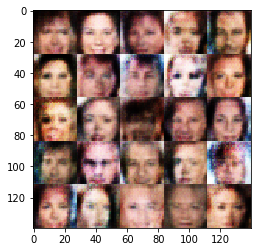

Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 1.3884
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 0.8457... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 1.2055
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 1.1996
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 0.7428... Generator Loss: 1.5840
Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 1.0849


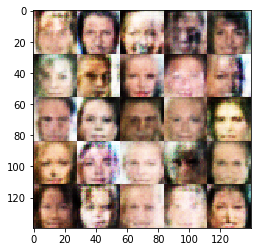

Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.1553
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.6144


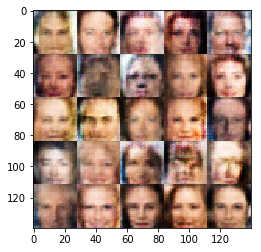

Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 1.3033
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.2936
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 1.4040
Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 0.9026


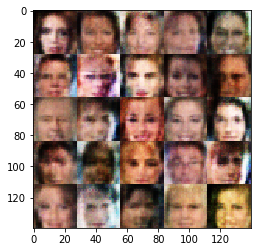

Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.2693
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.4661
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.4193
Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 1.8218
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 0.8405


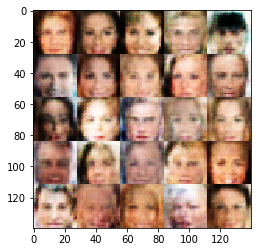

Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.3811
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.1611
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 0.6650


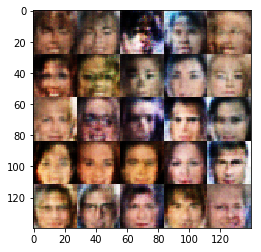

Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.2517
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 1.1618
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.5707
Epoch 1/1... Discriminator Loss: 0.7649... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.1858
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.1753


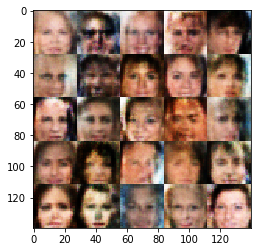

Epoch 1/1... Discriminator Loss: 0.7304... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 0.7123... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 1.2793
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.7009


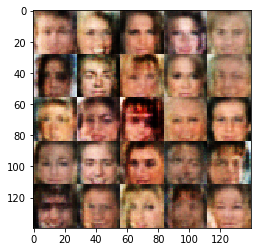

Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.1743
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 1.6776
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.6734


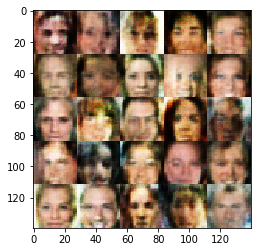

Epoch 1/1... Discriminator Loss: 0.6916... Generator Loss: 1.1839
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 1.2214
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.3861
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 1.3844
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 1.3290
Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 1.5923
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.8548
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 2.4609


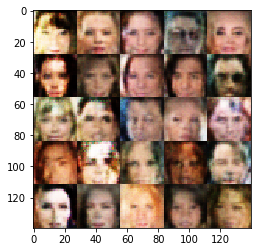

Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 0.4819... Generator Loss: 1.9950
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 0.6774... Generator Loss: 2.0021
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.4129
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 1.3962
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 0.5344... Generator Loss: 1.7254


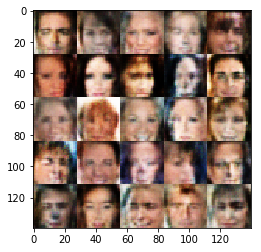

Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.4614
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 2.4397
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 1.3651
Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 2.2846
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 0.6153... Generator Loss: 1.9141


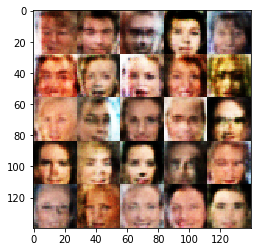

Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 1.4227
Epoch 1/1... Discriminator Loss: 0.3861... Generator Loss: 2.1300
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 1.4726
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 1.5177
Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 2.4144
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 1.5791
Epoch 1/1... Discriminator Loss: 0.5786... Generator Loss: 1.6892


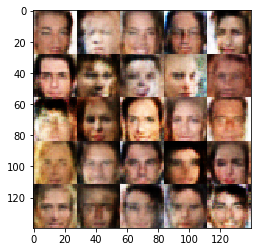

Epoch 1/1... Discriminator Loss: 0.7016... Generator Loss: 1.2310
Epoch 1/1... Discriminator Loss: 0.2729... Generator Loss: 2.3107
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 2.5618
Epoch 1/1... Discriminator Loss: 0.7376... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 1.4134
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 1.2254
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 0.5868... Generator Loss: 1.8743
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 0.8463


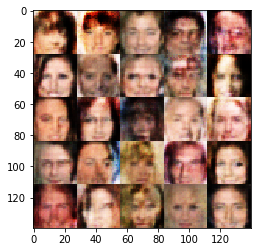

Epoch 1/1... Discriminator Loss: 0.4813... Generator Loss: 1.8464
Epoch 1/1... Discriminator Loss: 0.4695... Generator Loss: 2.0455
Epoch 1/1... Discriminator Loss: 0.3324... Generator Loss: 2.3666
Epoch 1/1... Discriminator Loss: 0.8455... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 0.6852... Generator Loss: 1.3180
Epoch 1/1... Discriminator Loss: 0.5555... Generator Loss: 1.4424


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.